## Kiva Loan Funding - Modeling

**PURPOSE**: Predict which microfinance loans will be funded

**AUTHOR** : Maureen Wiebe

**DATA SOURCES**:<br> 
- Kiva Developer Tools: https://www.kiva.org/build/data-snapshots
    
**REV DATE**: 5-4-2021

In [1]:
import pandas as pd 
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score,cohen_kappa_score
from sklearn.metrics import accuracy_score,log_loss
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score,auc
from sklearn.metrics import plot_confusion_matrix
plt.style.use('seaborn')
pd.set_option('max_columns', None)

### Import Data and Variables 

In [2]:
 loans_rand= pd.read_pickle('C:/Users/mwalz2/Documents/Python/Springboard/Kiva_Capstone_Project/data/interim/loans_rand_clean.pkl')

In [3]:
model_loans_rand= pd.read_pickle('C:/Users/mwalz2/Documents/Python/Springboard/Kiva_Capstone_Project/data/interim/model_loans_rand.pkl')

In [4]:
with open('trainingdatarand.pickle', 'rb') as f: 
    X, y, X_train, X_test, y_train, y_test,X_train_norm,X_test_norm, norm = pickle.load(f)

### Model Performance Summary
Create a dataframe to collect the key metrics for evaluating and comparing the performance of each model that is tested. 

In [5]:
model_performance = pd.DataFrame(columns = ['Model', 'Accuracy_F1_Score', 'Macro_Avg_Recall', 'Macro_Avg_F1_Score', 'Exp_Precision', 'Exp_Recall', 'Exp_F1_Score','Funded_Precision', 'Funded_Recall', 'Funded_F1_Score'])

### Baseline Model 
For this particular problem the baseline methodology for comparing future models will be to assign the dominant class (funded) to all loans.  This will be helpful to see if any models can do a better job of identifying the imbalanced class(expired). 

In [6]:
#For this dataset the baseline model will predict the majority class (funded) for all loans. This will provide us a baseline to predict against
model ='Baseline'
y_pred = [1 for i in range(len(y_test))]

report = classification_report(y_test, y_pred)

model_performance.loc[len(model_performance)] =[model,report[-123:-119], report[-79:-75], report[-69:-65],report[-252:-248],report[-242:-238],report[-232:-228],report[-198:-194],report[-188:-184],report[-178:-174]]

model_performance

C:\Users\mwalz2\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mwalz2\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mwalz2\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Accuracy_F1_Score,Macro_Avg_Recall,Macro_Avg_F1_Score,Exp_Precision,Exp_Recall,Exp_F1_Score,Funded_Precision,Funded_Recall,Funded_F1_Score
0,Baseline,0.94,0.50,0.49,0.00,0.00,0.00,0.94,1.00,0.97


### Random Forest Model 

In [7]:
from sklearn.ensemble import RandomForestClassifier
model ='Random Forest'
rf = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1)

rf.fit(X_train_norm, y_train)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [8]:
y_pred = rf.predict(X_test_norm)

report = classification_report(y_test, y_pred)

model_performance.loc[len(model_performance)] =[model,report[-123:-119], report[-79:-75], report[-69:-65],report[-252:-248],report[-242:-238],report[-232:-228],report[-198:-194],report[-188:-184],report[-178:-174]]

model_performance

,Model,Accuracy_F1_Score,Macro_Avg_Recall,Macro_Avg_F1_Score,Exp_Precision,Exp_Recall,Exp_F1_Score,Funded_Precision,Funded_Recall,Funded_F1_Score
0,Baseline,0.94,0.50,0.49,0.00,0.00,0.00,0.94,1.00,0.97
1,Random Forest,0.95,0.62,0.67,0.71,0.25,0.37,0.96,0.99,0.97


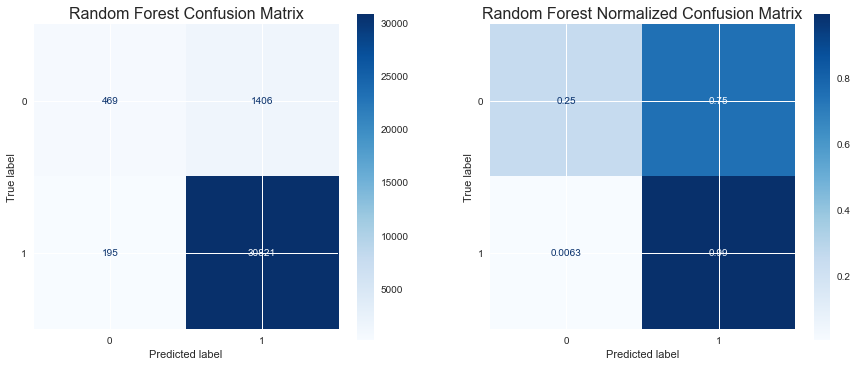

In [9]:
fig, (ax1, ax2) = plt.subplots(figsize = (15, 6), nrows = 1, ncols = 2)

plot_confusion_matrix(rf,X_test_norm, y_test,cmap=plt.cm.Blues, ax=ax1)
plot_confusion_matrix(rf,X_test_norm, y_test,cmap=plt.cm.Blues, normalize='true',ax=ax2)
ax1.set_title('Random Forest Confusion Matrix', fontsize =16)
ax2.set_title('Random Forest Normalized Confusion Matrix', fontsize =16)
plt.show()

45


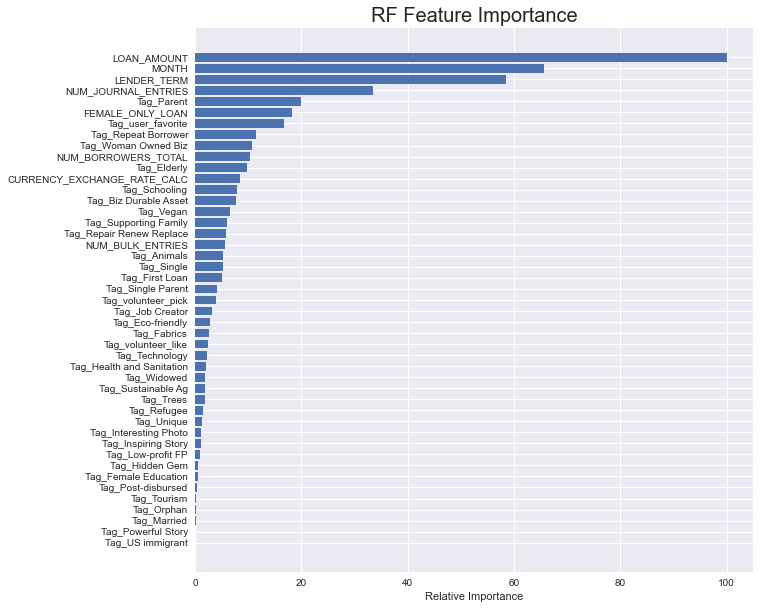

In [10]:
feature_importance = rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:45]
sorted_idx = np.argsort(feature_importance)[:45]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('RF Feature Importance', fontsize =20)
plt.show()

### Remove Time Component 
Although with the last 6 months of 2019 it appears that the month of the loan is highly impactful the overall dataset does not exhibit this same trend. Therefore we will assess the model without this information.  

In [12]:
X_monthless = X.drop('MONTH', axis = 1)

X_train_m, X_test_m, y_train, y_test = train_test_split(X_monthless, y,test_size=0.3, random_state =42)

#fit the scaler to the train dataset 
norm = MinMaxScaler().fit(X_train_m)

#transform the train dataset 
X_train_m_norm = norm.transform(X_train_m)

#transform the test dataset based on the scaler fitted to the train dataset to prevent any data leakage
X_test_m_norm = norm.transform(X_test_m)

In [13]:
model ='Random Forest (No Month)'
rf_monthless = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1)

rf_monthless.fit(X_train_m_norm, y_train)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [14]:
y_pred = rf_monthless.predict(X_test_m_norm)

report = classification_report(y_test, y_pred)

model_performance.loc[len(model_performance)] =[model,report[-123:-119], report[-79:-75], report[-69:-65],report[-252:-248],report[-242:-238],report[-232:-228],report[-198:-194],report[-188:-184],report[-178:-174]]

model_performance

,Model,Accuracy_F1_Score,Macro_Avg_Recall,Macro_Avg_F1_Score,Exp_Precision,Exp_Recall,Exp_F1_Score,Funded_Precision,Funded_Recall,Funded_F1_Score
0,Baseline,0.94,0.50,0.49,0.00,0.00,0.00,0.94,1.00,0.97
1,Random Forest,0.95,0.62,0.67,0.71,0.25,0.37,0.96,0.99,0.97
2,Random Forest (No Month),0.95,0.62,0.66,0.66,0.24,0.36,0.96,0.99,0.97


45


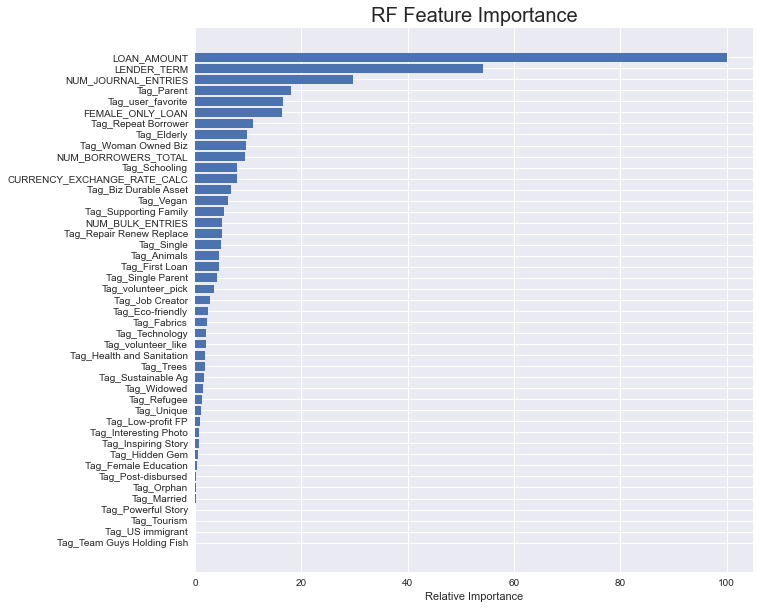

In [15]:
feature_importance = rf_monthless.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:45]
sorted_idx = np.argsort(feature_importance)[:45]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_monthless.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('RF Feature Importance', fontsize =20)
plt.show()

### SMOTE (Synthetic Minority Oversampling Technique)
+ Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
+ Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.
https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

#fit the scaler to the train dataset 
norm = MinMaxScaler().fit(X_train)

#transform the train dataset 
X_train_norm = norm.transform(X_train)

#transform the test dataset based on the scaler fitted to the train dataset to prevent any data leakage
X_test_norm = norm.transform(X_test)

In [17]:
from imblearn.over_sampling import SMOTE 


sm = SMOTE(random_state=42)

X_train_sm, y_train_sm = sm.fit_resample(X_train_norm, y_train)

print(X_train_norm.shape, X_train_sm.shape)

(76743, 745) (144866, 745)


In [18]:
rf_sm = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1)

rf_sm.fit(X_train_sm, y_train_sm)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [19]:
model ='SMOTE Random Forest'

y_pred =rf_sm.predict(X_test_norm)

report = classification_report(y_test, y_pred)

model_performance.loc[len(model_performance)] =[model,report[-123:-119], report[-79:-75], report[-69:-65],report[-252:-248],report[-242:-238],report[-232:-228],report[-198:-194],report[-188:-184],report[-178:-174]]

model_performance

,Model,Accuracy_F1_Score,Macro_Avg_Recall,Macro_Avg_F1_Score,Exp_Precision,Exp_Recall,Exp_F1_Score,Funded_Precision,Funded_Recall,Funded_F1_Score
0,Baseline,0.94,0.50,0.49,0.00,0.00,0.00,0.94,1.00,0.97
1,Random Forest,0.95,0.62,0.67,0.71,0.25,0.37,0.96,0.99,0.97
2,Random Forest (No Month),0.95,0.62,0.66,0.66,0.24,0.36,0.96,0.99,0.97
3,SMOTE Random Forest,0.95,0.69,0.72,0.58,0.40,0.48,0.96,0.98,0.97


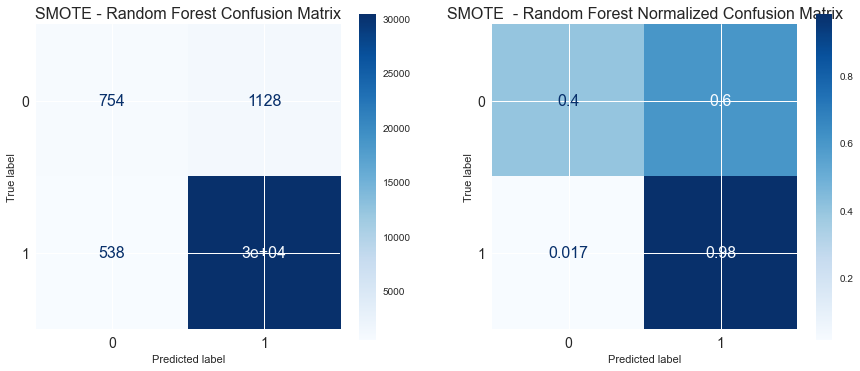

In [119]:
fig, (ax1, ax2) = plt.subplots(figsize = (15, 6), nrows = 1, ncols = 2)
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(rf_sm,X_test_norm, y_test,cmap=plt.cm.Blues, ax=ax1)
plot_confusion_matrix(rf_sm,X_test_norm, y_test,cmap=plt.cm.Blues, normalize='true',ax=ax2)
ax1.set_title('SMOTE - Random Forest Confusion Matrix', fontsize =16)
ax2.set_title('SMOTE  - Random Forest Normalized Confusion Matrix', fontsize =16)
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)
plt.show()

In [145]:
result = pd.DataFrame(rf_sm.predict_proba(X_test_norm),y_test)
result = pd.DataFrame(result.to_records())
result[(result.Status_funded ==0) &(result['0']<0.5)]

,Status_funded,0,1
18,0,0.43,0.57
20,0,0.36,0.64
45,0,0.18,0.82
60,0,0.20,0.80
72,0,0.07,0.93
...,...,...,...
32816,0,0.03,0.97
32830,0,0.46,0.54
32873,0,0.10,0.90
32882,0,0.32,0.68


25


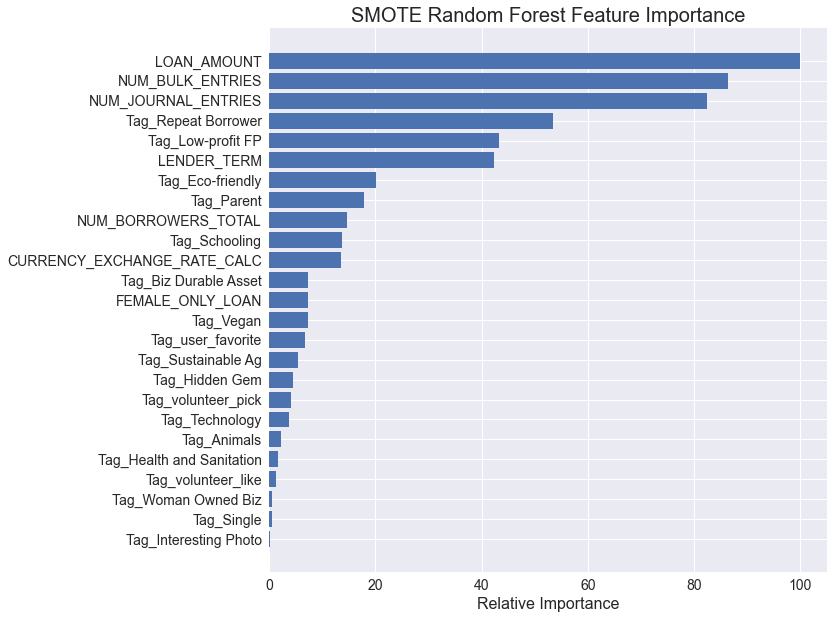

In [127]:
feature_importance = rf_sm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:25]
sorted_idx = np.argsort(feature_importance)[:25]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_monthless.columns[sorted_idx])
plt.xlabel('Relative Importance', fontsize = 16)
plt.title('SMOTE Random Forest Feature Importance', fontsize =20)
plt.yticks(fontsize =14)
plt.xticks(fontsize =14)
plt.show()

### UnderSampling

In [21]:
from sklearn.utils import resample 
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy ='majority')

X_train_under, y_train_under = undersample.fit_resample(X_train_norm, y_train)

In [22]:
model ='UnderSampled Random Forest'
rf_under = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1)

rf_under.fit(X_train_under, y_train_under)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [23]:
y_pred =rf_under.predict(X_test_norm)

report = classification_report(y_test, y_pred)

model_performance.loc[len(model_performance)] =[model,report[-123:-119], report[-79:-75], report[-69:-65],report[-252:-248],report[-242:-238],report[-232:-228],report[-198:-194],report[-188:-184],report[-178:-174]]

model_performance

,Model,Accuracy_F1_Score,Macro_Avg_Recall,Macro_Avg_F1_Score,Exp_Precision,Exp_Recall,Exp_F1_Score,Funded_Precision,Funded_Recall,Funded_F1_Score
0,Baseline,0.94,0.50,0.49,0.00,0.00,0.00,0.94,1.00,0.97
1,Random Forest,0.95,0.62,0.67,0.71,0.25,0.37,0.96,0.99,0.97
2,Random Forest (No Month),0.95,0.62,0.66,0.66,0.24,0.36,0.96,0.99,0.97
3,SMOTE Random Forest,0.95,0.69,0.72,0.58,0.40,0.48,0.96,0.98,0.97
4,UnderSampled Random Forest,0.84,0.88,0.65,0.26,0.93,0.40,1.00,0.83,0.91


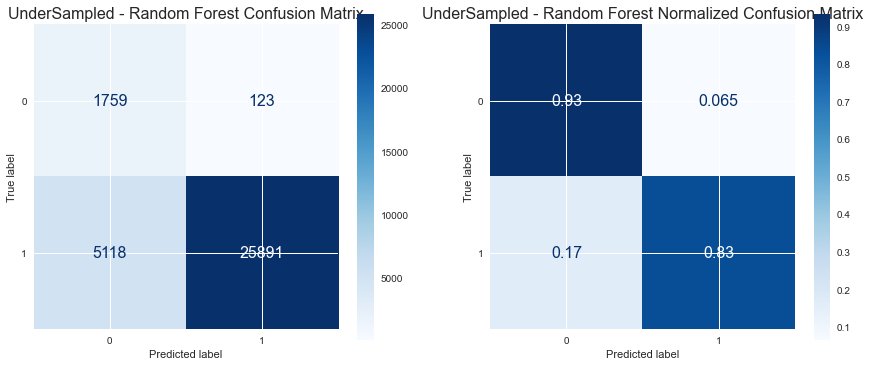

In [114]:
fig, (ax1, ax2) = plt.subplots(figsize = (15, 6), nrows = 1, ncols = 2)
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(rf_under,X_test_norm, y_test,cmap=plt.cm.Blues, ax=ax1)
plot_confusion_matrix(rf_under,X_test_norm, y_test,cmap=plt.cm.Blues, normalize='true',ax=ax2)
ax1.set_title('UnderSampled - Random Forest Confusion Matrix', fontsize =16)
ax2.set_title('UnderSampled - Random Forest Normalized Confusion Matrix', fontsize =16)
plt.show()

### Logistic Regression Model

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model ='Logistic Regression'

logreg = LogisticRegression(max_iter = 1000)

logreg.fit(X_train_norm, y_train)

y_pred = logreg.predict(X_test_norm)

In [26]:
report = classification_report(y_test, y_pred)

model_performance.loc[len(model_performance)] =[model,report[-123:-119], report[-79:-75], report[-69:-65],report[-252:-248],report[-242:-238],report[-232:-228],report[-198:-194],report[-188:-184],report[-178:-174]]

model_performance

,Model,Accuracy_F1_Score,Macro_Avg_Recall,Macro_Avg_F1_Score,Exp_Precision,Exp_Recall,Exp_F1_Score,Funded_Precision,Funded_Recall,Funded_F1_Score
0,Baseline,0.94,0.50,0.49,0.00,0.00,0.00,0.94,1.00,0.97
1,Random Forest,0.95,0.62,0.67,0.71,0.25,0.37,0.96,0.99,0.97
2,Random Forest (No Month),0.95,0.62,0.66,0.66,0.24,0.36,0.96,0.99,0.97
3,SMOTE Random Forest,0.95,0.69,0.72,0.58,0.40,0.48,0.96,0.98,0.97
4,UnderSampled Random Forest,0.84,0.88,0.65,0.26,0.93,0.40,1.00,0.83,0.91
5,Logistic Regression,0.94,0.56,0.58,0.60,0.12,0.19,0.95,1.00,0.97


### Weighted Logistic Regression

In [27]:
model ='Weighted Logistic Regression'

weights = {0:85.0, 1:3.0}

wgt_logreg = LogisticRegression(random_state = 42, class_weight = weights, max_iter = 1000)

wgt_logreg.fit(X_train_norm, y_train)

LogisticRegression(class_weight={0: 85.0, 1: 3.0}, max_iter=1000,
                   random_state=42)

In [28]:
y_pred = wgt_logreg.predict(X_test_norm)

report = classification_report(y_test, y_pred)

model_performance.loc[len(model_performance)] =[model,report[-123:-119], report[-79:-75], report[-69:-65],report[-252:-248],report[-242:-238],report[-232:-228],report[-198:-194],report[-188:-184],report[-178:-174]]

model_performance

,Model,Accuracy_F1_Score,Macro_Avg_Recall,Macro_Avg_F1_Score,Exp_Precision,Exp_Recall,Exp_F1_Score,Funded_Precision,Funded_Recall,Funded_F1_Score
0,Baseline,0.94,0.50,0.49,0.00,0.00,0.00,0.94,1.00,0.97
1,Random Forest,0.95,0.62,0.67,0.71,0.25,0.37,0.96,0.99,0.97
2,Random Forest (No Month),0.95,0.62,0.66,0.66,0.24,0.36,0.96,0.99,0.97
3,SMOTE Random Forest,0.95,0.69,0.72,0.58,0.40,0.48,0.96,0.98,0.97
4,UnderSampled Random Forest,0.84,0.88,0.65,0.26,0.93,0.40,1.00,0.83,0.91
5,Logistic Regression,0.94,0.56,0.58,0.60,0.12,0.19,0.95,1.00,0.97
6,Weighted Logistic Regression,0.81,0.87,0.63,0.23,0.94,0.37,1.00,0.80,0.89


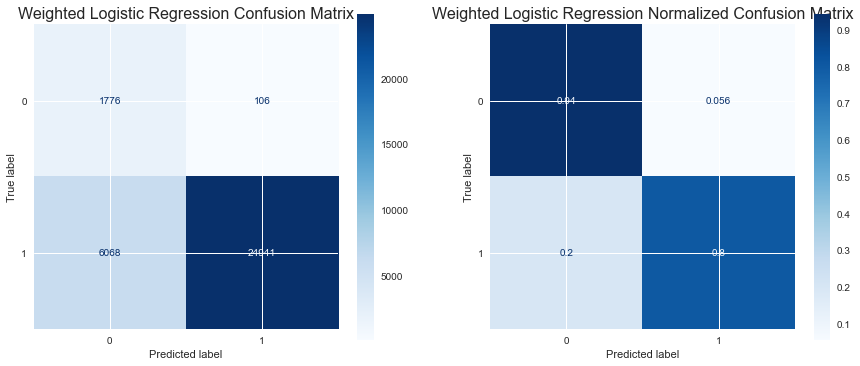

In [29]:
fig, (ax1, ax2) = plt.subplots(figsize = (15, 6), nrows = 1, ncols = 2)

plot_confusion_matrix(wgt_logreg,X_test_norm, y_test,cmap=plt.cm.Blues, ax=ax1)
plot_confusion_matrix(wgt_logreg,X_test_norm, y_test,cmap=plt.cm.Blues, normalize='true',ax=ax2)
ax1.set_title('Weighted Logistic Regression Confusion Matrix', fontsize =16)
ax2.set_title('Weighted Logistic Regression Normalized Confusion Matrix', fontsize =16)
plt.show()

### SVM & Weighted SVM

In [31]:
from sklearn.svm import SVC

model ='Support Vector Machine (SVM)'

svm = SVC(gamma='scale')

svm.fit(X_train_norm, y_train)

SVC()

In [32]:
y_pred = svm.predict(X_test_norm)

report = classification_report(y_test, y_pred)

model_performance.loc[len(model_performance)] =[model,report[-123:-119], report[-79:-75], report[-69:-65],report[-252:-248],report[-242:-238],report[-232:-228],report[-198:-194],report[-188:-184],report[-178:-174]]

model_performance


,Model,Accuracy_F1_Score,Macro_Avg_Recall,Macro_Avg_F1_Score,Exp_Precision,Exp_Recall,Exp_F1_Score,Funded_Precision,Funded_Recall,Funded_F1_Score
0,Baseline,0.94,0.50,0.49,0.00,0.00,0.00,0.94,1.00,0.97
1,Random Forest,0.95,0.62,0.67,0.71,0.25,0.37,0.96,0.99,0.97
2,Random Forest (No Month),0.95,0.62,0.66,0.66,0.24,0.36,0.96,0.99,0.97
3,SMOTE Random Forest,0.95,0.69,0.72,0.58,0.40,0.48,0.96,0.98,0.97
4,UnderSampled Random Forest,0.84,0.88,0.65,0.26,0.93,0.40,1.00,0.83,0.91
5,Logistic Regression,0.94,0.56,0.58,0.60,0.12,0.19,0.95,1.00,0.97
6,Weighted Logistic Regression,0.81,0.87,0.63,0.23,0.94,0.37,1.00,0.80,0.89
7,Support Vector Machine (SVM),0.94,0.50,0.49,0.47,0.00,0.01,0.94,1.00,0.97


In [34]:
model ='Weighted Support Vector Machine (SVM)'
weights = {0:100.0, 1:1.0}

wgt_svm  = SVC(gamma='scale', class_weight=weights)

wgt_svm.fit(X_train_norm, y_train)


SVC(class_weight={0: 100.0, 1: 1.0})

In [35]:
y_pred = wgt_svm.predict(X_test_norm)

report = classification_report(y_test, y_pred)

model_performance.loc[len(model_performance)] =[model,report[-123:-119], report[-79:-75], report[-69:-65],report[-252:-248],report[-242:-238],report[-232:-228],report[-198:-194],report[-188:-184],report[-178:-174]]

model_performance

,Model,Accuracy_F1_Score,Macro_Avg_Recall,Macro_Avg_F1_Score,Exp_Precision,Exp_Recall,Exp_F1_Score,Funded_Precision,Funded_Recall,Funded_F1_Score
0,Baseline,0.94,0.50,0.49,0.00,0.00,0.00,0.94,1.00,0.97
1,Random Forest,0.95,0.62,0.67,0.71,0.25,0.37,0.96,0.99,0.97
2,Random Forest (No Month),0.95,0.62,0.66,0.66,0.24,0.36,0.96,0.99,0.97
3,SMOTE Random Forest,0.95,0.69,0.72,0.58,0.40,0.48,0.96,0.98,0.97
4,UnderSampled Random Forest,0.84,0.88,0.65,0.26,0.93,0.40,1.00,0.83,0.91
5,Logistic Regression,0.94,0.56,0.58,0.60,0.12,0.19,0.95,1.00,0.97
6,Weighted Logistic Regression,0.81,0.87,0.63,0.23,0.94,0.37,1.00,0.80,0.89
7,Support Vector Machine (SVM),0.94,0.50,0.49,0.47,0.00,0.01,0.94,1.00,0.97
8,Weighted Support Vector Machine (SVM),0.84,0.82,0.64,0.24,0.80,0.37,0.99,0.84,0.91


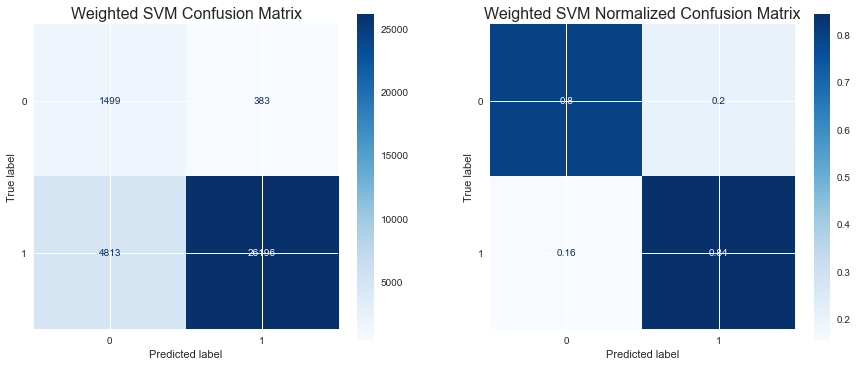

In [37]:
fig, (ax1, ax2) = plt.subplots(figsize = (15, 6), nrows = 1, ncols = 2)

plot_confusion_matrix(wgt_svm,X_test_norm, y_test,cmap=plt.cm.Blues, ax=ax1)
plot_confusion_matrix(wgt_svm,X_test_norm, y_test,cmap=plt.cm.Blues, normalize='true',ax=ax2)
ax1.set_title('Weighted SVM Confusion Matrix', fontsize =16)
ax2.set_title('Weighted SVM Normalized Confusion Matrix', fontsize =16)
plt.show()

In [85]:
model_summary = model_performance[['Model','Accuracy_F1_Score','Exp_Precision','Exp_Recall','Exp_F1_Score']]
model_summary.columns=['Model','Overall Accuracy','Expired Precision','Expired Recall','Expired F1 Score']
model_summary[['Overall Accuracy','Expired Precision','Expired Recall','Expired F1 Score']] = model_summary[['Overall Accuracy','Expired Precision','Expired Recall','Expired F1 Score']].apply(pd.to_numeric)
model_summary

,Model,Overall Accuracy,Expired Precision,Expired Recall,Expired F1 Score
0,Baseline,0.94,0.00,0.00,0.00
1,Random Forest,0.95,0.71,0.25,0.37
2,Random Forest (No Month),0.95,0.66,0.24,0.36
3,SMOTE Random Forest,0.95,0.58,0.40,0.48
4,UnderSampled Random Forest,0.84,0.26,0.93,0.40
5,Logistic Regression,0.94,0.60,0.12,0.19
6,Weighted Logistic Regression,0.81,0.23,0.94,0.37
7,Support Vector Machine (SVM),0.94,0.47,0.00,0.01
8,Weighted Support Vector Machine (SVM),0.84,0.24,0.80,0.37


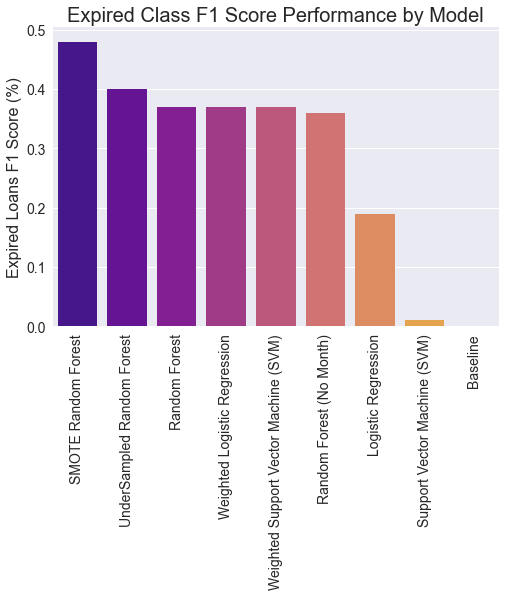

In [109]:
sns.barplot(data = model_performance.sort_values('Exp_F1_Score', ascending =False), x='Model', y=pd.to_numeric(model_performance.Exp_F1_Score), palette='plasma')
plt.xticks(rotation=90, fontsize = 14)
plt.xlabel('')
plt.ylabel('Expired Loans F1 Score (%)', fontsize =16)
plt.title('Expired Class F1 Score Performance by Model', fontsize =20)
plt.yticks(fontsize =14)
plt.show()

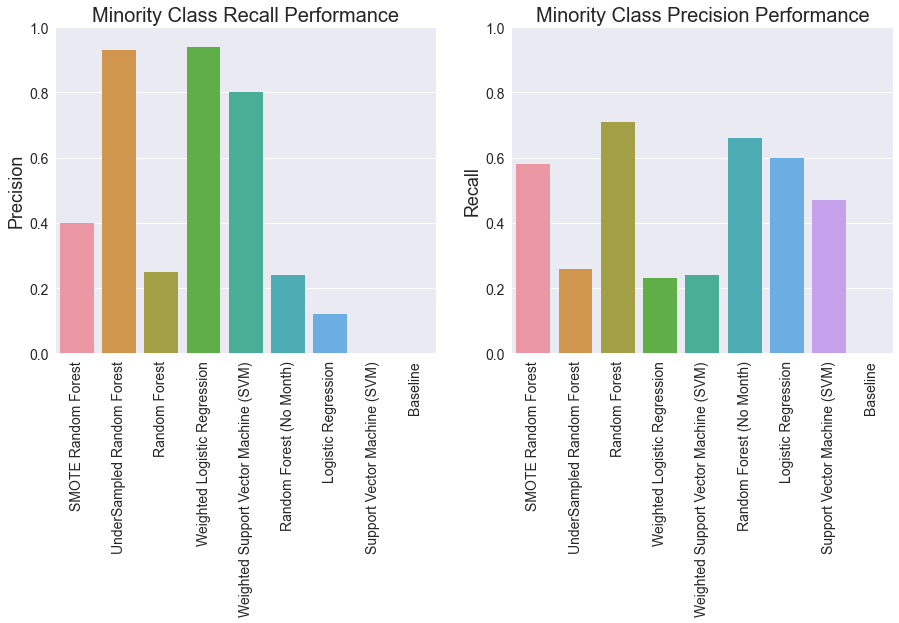

In [62]:
fig, ax = plt.subplots(figsize = (15, 6), nrows = 1, ncols = 2)
sns.barplot(data = model_performance.sort_values('Exp_F1_Score', ascending =False), x='Model', y=pd.to_numeric(model_performance.Exp_Recall),ax= ax[0])
sns.barplot(data = model_performance.sort_values('Exp_F1_Score', ascending =False), x='Model', y=pd.to_numeric(model_performance.Exp_Precision),ax= ax[1])
ax[0].tick_params(axis='x', rotation=90,labelsize =14)
ax[1].tick_params(axis='x', rotation=90,labelsize =14)
ax[0].tick_params(axis='y', labelsize =14)
ax[1].tick_params(axis='y', labelsize =14)
ax[0].set_title('Minority Class Recall Performance', fontsize=20)
ax[1].set_title('Minority Class Precision Performance', fontsize=20)
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[1].set_ylabel('Recall', fontsize=18)
ax[0].set_ylabel('Precision', fontsize=18)
ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)
plt.show()

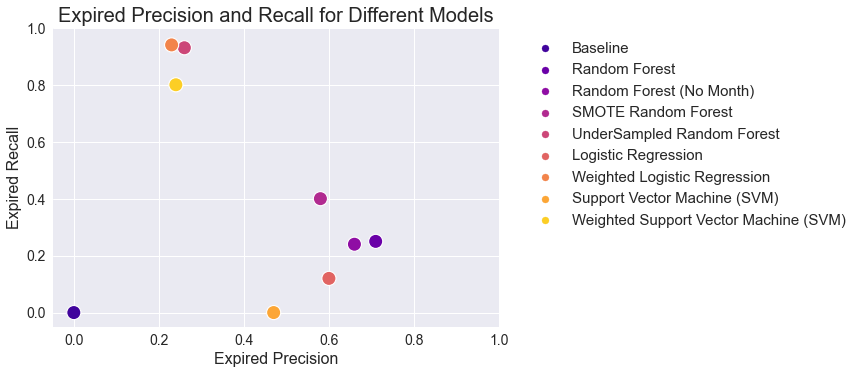

In [113]:
sns.scatterplot(data = model_summary, x='Expired Precision', y='Expired Recall', hue = 'Model', palette='plasma', s= 200)
plt.xlim(-.05,1)
plt.ylim(-.05,1)
plt.title("Expired Precision and Recall for Different Models", fontsize =20)
plt.xlabel('Expired Precision', fontsize =16)
plt.ylabel('Expired Recall', fontsize =16)
plt.xticks(fontsize =14)
plt.yticks(fontsize =14)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize =15)
plt.show()